# Predicting ground states for 2D Heisenberg models

In [11]:
# Basic functionalities
import numpy as np
import random
import copy
import ast
import datetime as dt
from timeit import default_timer as timer
from os import path

# Neural tangent kernel
import jax
from neural_tangents import stax

# Traditional ML methods and techniques
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [8]:
# Load data

length = 5 # length = 4, 5, 6, 7, 8, 9 are all available

Xfull = [] # Shape = (number of data) x (number of params)
Ytrain = [] # Shape = (number of data) x (number of pairs), estimated 2-point correlation functions
Yfull = [] # Shape = (number of data) x (number of pairs), exact 2-point correlation functions

for idx in range(1, 101):
    if path.exists('./heisenberg_data/heisenberg_{}x5_id{}_XX.txt'.format(length, idx)) == False:
        continue
    with open('./heisenberg_data/heisenberg_{}x5_id{}_samples.txt'.format(length, idx), 'r') as f:
        single_data = []
        classical_shadow = [[int(c) for i, c in enumerate(line.split("\t"))] for line in f]
        for i in range(length * 5):
            for j in range(length * 5):
                if i == j:
                    single_data.append(1.0)
                    continue
                corr = 0
                cnt = 0
                for shadow in classical_shadow:
                    if shadow[i] // 2 == shadow[j] // 2:
                        corr += 3 if shadow[i] % 2 == shadow[j] % 2 else -3
                    cnt += 1
                single_data.append(corr / cnt)
        Ytrain.append(single_data)
    with open('./heisenberg_data/heisenberg_{}x5_id{}_XX.txt'.format(length, idx), 'r') as f:
        single_data = []
        for line in f:
            for i, c in enumerate(line.split("\t")):
                v = float(c)
                single_data.append(v)
        Yfull.append(single_data)
    with open('./heisenberg_data/heisenberg_{}x5_id{}_couplings.txt'.format(length, idx), 'r') as f:
        single_data = []
        for line in f:
            for i, c in enumerate(line.split("\t")):
                v = float(c)
                single_data.append(v)
        Xfull.append(single_data)

Xfull = np.array(Xfull)
print("number of data (N) * number of params (m) =", Xfull.shape)
Ytrain = np.array(Ytrain)
Yfull = np.array(Yfull)
print("number of data (N) * number of pairs =", Yfull.shape)


number of data (N) * number of params (m) = (100, 40)
number of data (N) * number of pairs = (100, 625)


In [9]:
#
# Dirichlet kernel
#

kernel_dir = np.zeros((len(Xfull), Xfull.shape[1]*5))
for i, x1 in enumerate(Xfull):
    cnt = 0
    for k in range(len(x1)):
        for k1 in range(-2, 3):
            kernel_dir[i, cnt] += np.cos(np.pi * k1 * x1[k])
            cnt += 1
print("constructed Dirichlet kernel")
            
#
# Neural tangent kernel
#
    
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(1)
)
kernel_NN2 = kernel_fn(Xfull, Xfull, 'ntk')

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(1)
)
kernel_NN3 = kernel_fn(Xfull, Xfull, 'ntk')
                
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(1)
)
kernel_NN4 = kernel_fn(Xfull, Xfull, 'ntk')

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(32), stax.Relu(),
    stax.Dense(1)
)
kernel_NN5 = kernel_fn(Xfull, Xfull, 'ntk')

list_kernel_NN = [kernel_NN2, kernel_NN3, kernel_NN4, kernel_NN5]

for r in range(len(list_kernel_NN)):
    for i in range(len(list_kernel_NN[r])):
        for j in range(len(list_kernel_NN[r])):
            list_kernel_NN[r][i][j] /= (list_kernel_NN[r][i][i] * list_kernel_NN[r][j][j]) ** 0.5
print("constructed neural tangent kernel")
            
#
# RBF kernel is defined in Sklearn
#
print("RBF kernel (will be constructed in sklearn)")


constructed Dirichlet kernel
constructed neural tangent kernel
RBF kernel (will be constructed in sklearn)


In [21]:
train_idx, test_idx, _, _ = train_test_split(range(len(Xfull)), range(len(Xfull)), test_size=0.4, random_state=0)

for k in range((length * 5) * (length * 5)):
    # each k corresponds to the correlation function in a pair of qubits
    print("k =", k)

    def train_and_predict(kernel, opt="linear"): # opt="linear" or "rbf"
        
        # instance-wise normalization
        for i in range(len(kernel)):
            kernel[i] /= np.linalg.norm(kernel[i])

        # consider the k-th pair
        global k
        
        # training data (estimated from measurement data)
        y = np.array([Ytrain[i][k] for i in range(len(Xfull))])
        X_train, X_test, y_train, y_test = train_test_split(kernel, y, test_size=0.4, random_state=0)

        # testing data (exact expectation values)
        y_clean = np.array([Yfull[i][k] for i in range(len(Xfull))])
        _, _, _, y_test_clean = train_test_split(kernel, y_clean, test_size=0.4, random_state=0)

        # use cross validation to find the best method + hyper-param
        best_cv_score, test_score = 999.0, 999.0
        for ML_method in [(lambda Cx: svm.SVR(kernel=opt, C=Cx)), (lambda Cx: KernelRidge(kernel=opt, alpha=1/(2*Cx)))]:
            for C in [0.0125, 0.025, 0.05, 0.125, 0.25, 0.5, 1.0, 2.0]:
                score = -np.mean(cross_val_score(ML_method(C), X_train, y_train, cv=5, scoring="neg_root_mean_squared_error"))
                if best_cv_score > score:
                    clf = ML_method(C).fit(X_train, y_train.ravel())
                    test_score = np.linalg.norm(clf.predict(X_test).ravel() - y_test_clean.ravel()) / (len(y_test) ** 0.5)
                    best_cv_score = score
                
        return best_cv_score, test_score

    # Dirichlet
    print("Dirich. kernel", train_and_predict(kernel_dir))
    # RBF
    print("Gaussi. kernel", train_and_predict(Xfull, opt="rbf"))
    # Neural tangent
    for kernel_NN in list_kernel_NN:
        print("Neur. T kernel", train_and_predict(kernel_NN))


k = 0
Dirich. kernel (-0.0, 1.510066572755813e-16)
Gaussi. kernel (-0.0, 1.510066572755813e-16)
Neur. T kernel (-0.0, 1.510066572755813e-16)
Neur. T kernel (-0.0, 1.510066572755813e-16)
Neur. T kernel (-0.0, 1.510066572755813e-16)
Neur. T kernel (-0.0, 1.510066572755813e-16)
k = 1
Dirich. kernel (0.2201811394339058, 0.22367748847720303)
Gaussi. kernel (0.1906479726200878, 0.20233677894425678)
Neur. T kernel (0.20982793995212662, 0.21655192591685818)
Neur. T kernel (0.2065027197565533, 0.21436849198491903)
Neur. T kernel (0.2032498799725277, 0.21278346284511718)
Neur. T kernel (0.2011081697155991, 0.2110627151528023)
k = 2
Dirich. kernel (0.09791798528290546, 0.08075685634118952)
Gaussi. kernel (0.09390530058212912, 0.07624636985287254)
Neur. T kernel (0.09437298620681231, 0.07552155935987165)
Neur. T kernel (0.09346939295707744, 0.07415461872922223)
Neur. T kernel (0.09365024406014114, 0.07412773436291352)
Neur. T kernel (0.09460528993040832, 0.07530478318327129)
k = 3
Dirich. kernel (

Neur. T kernel (0.06073729759956953, 0.04210713207534007)
Neur. T kernel (0.06059206994697465, 0.04194470311471854)
k = 24
Dirich. kernel (0.07348482164846994, 0.044162176164541656)
Gaussi. kernel (0.07335194545955001, 0.043896181282643214)
Neur. T kernel (0.07384674351751469, 0.04379260282684897)
Neur. T kernel (0.07354888444467372, 0.04336022658356907)
Neur. T kernel (0.07321048580902541, 0.04291082949741562)
Neur. T kernel (0.07290639101489489, 0.042534407604173624)
k = 25
Dirich. kernel (0.2201811394339058, 0.22367748847720303)
Gaussi. kernel (0.1906479726200878, 0.20233677894425678)
Neur. T kernel (0.20982793995212662, 0.21655192591685818)
Neur. T kernel (0.2065027197565533, 0.21436849198491903)
Neur. T kernel (0.2032498799725277, 0.21278346284511718)
Neur. T kernel (0.2011081697155991, 0.2110627151528023)
k = 26
Dirich. kernel (-0.0, 3.3628946806942745e-16)
Gaussi. kernel (-0.0, 3.3628946806942745e-16)
Neur. T kernel (-0.0, 3.3628946806942745e-16)
Neur. T kernel (-0.0, 3.36289468

Gaussi. kernel (0.07138095916481663, 0.04972789171536016)
Neur. T kernel (0.07139382105409986, 0.050107236898981326)
Neur. T kernel (0.0712795688057353, 0.04945397834717622)
Neur. T kernel (0.07106037083068222, 0.0494066782911391)
Neur. T kernel (0.07080166792699713, 0.049389625786125296)
k = 48
Dirich. kernel (0.0623589416572368, 0.03412649236156188)
Gaussi. kernel (0.06344509678208453, 0.031755544197011105)
Neur. T kernel (0.06349688092902998, 0.03181572037366596)
Neur. T kernel (0.06349677633536784, 0.031811560448665906)
Neur. T kernel (0.06349459061615728, 0.0318061597114217)
Neur. T kernel (0.06348333127048122, 0.031747922522419106)
k = 49
Dirich. kernel (0.0660249560176906, 0.03818910872808697)
Gaussi. kernel (0.0657724207523196, 0.03837115695335258)
Neur. T kernel (0.06600776654740881, 0.03793423750909342)
Neur. T kernel (0.06600913404032777, 0.03793089772255763)
Neur. T kernel (0.0660126922269362, 0.037923734362936994)
Neur. T kernel (0.06602048594138746, 0.037910753258632045)


Neur. T kernel (0.05969351762486051, 0.05533524499266662)
Neur. T kernel (0.05969393740481608, 0.05530428034905055)
k = 71
Dirich. kernel (0.07401064738549887, 0.06626309697500096)
Gaussi. kernel (0.07314809161777913, 0.059903556656120176)
Neur. T kernel (0.07368636334495436, 0.06146748145137324)
Neur. T kernel (0.07352173030063228, 0.060206774515622605)
Neur. T kernel (0.07334924665127493, 0.06005018655890989)
Neur. T kernel (0.07320605488552653, 0.05988452680366649)
k = 72
Dirich. kernel (0.0632682989683631, 0.05726686764924227)
Gaussi. kernel (0.06344824854503758, 0.05553072772608731)
Neur. T kernel (0.06347496750438823, 0.055404152053788944)
Neur. T kernel (0.06347272716006061, 0.05551299697950216)
Neur. T kernel (0.06344688910765764, 0.055493687242655666)
Neur. T kernel (0.06339037080535996, 0.055501143603520924)
k = 73
Dirich. kernel (0.05642088536288722, 0.04119207054219452)
Gaussi. kernel (0.055601343201684125, 0.04115308057165339)
Neur. T kernel (0.0557178751461936, 0.04085812

Gaussi. kernel (0.07415706962573633, 0.0555482559947173)
Neur. T kernel (0.07684492364910192, 0.06043569306188212)
Neur. T kernel (0.07542280942852866, 0.05543602487367903)
Neur. T kernel (0.07448456468216577, 0.05610596052103558)
Neur. T kernel (0.07466855500562675, 0.055995705048143794)
k = 95
Dirich. kernel (0.06760351988861438, 0.04362685334921019)
Gaussi. kernel (0.06604861607385103, 0.041423020484666846)
Neur. T kernel (0.06621985901488363, 0.042962601446807226)
Neur. T kernel (0.06622724144028425, 0.04295773907083809)
Neur. T kernel (0.06618263239629545, 0.041182495112023175)
Neur. T kernel (0.06598650145191928, 0.041189797128436983)
k = 96
Dirich. kernel (0.06087292397450732, 0.041341467677744353)
Gaussi. kernel (0.061359723575887024, 0.039916382010233745)
Neur. T kernel (0.06113124306626035, 0.03923891985238191)
Neur. T kernel (0.06113352950885416, 0.039234498615481984)
Neur. T kernel (0.06113622445032476, 0.03922865122941501)
Neur. T kernel (0.06114130209936377, 0.03922153335

Neur. T kernel (0.07603052891557316, 0.05722537201609006)
k = 118
Dirich. kernel (0.06464336427402656, 0.05404055274432468)
Gaussi. kernel (0.062140057315812666, 0.05320645124765898)
Neur. T kernel (0.06267902125660214, 0.05376969570102335)
Neur. T kernel (0.062347308533435154, 0.05372820758431336)
Neur. T kernel (0.06202247080977154, 0.05369593326097351)
Neur. T kernel (0.061799310691420715, 0.05365695728897492)
k = 119
Dirich. kernel (0.09611651378780482, 0.08606548490282054)
Gaussi. kernel (0.0948534174105661, 0.08638343665478035)
Neur. T kernel (0.09485788324673809, 0.0864572641986564)
Neur. T kernel (0.09483611688789743, 0.08641693562057232)
Neur. T kernel (0.0947980231317076, 0.08637628832989339)
Neur. T kernel (0.09473611178508148, 0.08635403523797408)
k = 120
Dirich. kernel (0.062185372267841335, 0.04424263115835626)
Gaussi. kernel (0.061869781286616785, 0.04386416262735819)
Neur. T kernel (0.06219526756334128, 0.043151236143359556)
Neur. T kernel (0.06197869276167658, 0.043287

Gaussi. kernel (0.0753082036679312, 0.06233118702706348)
Neur. T kernel (0.07538784470863662, 0.05994396808723529)
Neur. T kernel (0.0747524376926805, 0.06044017109315486)
Neur. T kernel (0.07521556785034093, 0.06168941632845177)
Neur. T kernel (0.07548289160191021, 0.06097651850758212)
k = 142
Dirich. kernel (0.06430755286508852, 0.05223118893979659)
Gaussi. kernel (0.0644500427707547, 0.04940107134794513)
Neur. T kernel (0.063697645481884, 0.04749323538847416)
Neur. T kernel (0.06366482203674424, 0.04703700132999108)
Neur. T kernel (0.0636461980858549, 0.046589102512201344)
Neur. T kernel (0.06363658638302724, 0.04626235704563829)
k = 143
Dirich. kernel (0.06598070906043528, 0.058678031327515555)
Gaussi. kernel (0.07409476081564144, 0.04030273702702543)
Neur. T kernel (0.07447570240562984, 0.0396297403473463)
Neur. T kernel (0.07436121189916838, 0.03964274716173241)
Neur. T kernel (0.07427833830594813, 0.03971161863906533)
Neur. T kernel (0.07425544989508572, 0.039812381604875276)
k 

Neur. T kernel (0.0696187696311793, 0.04067036309512119)
k = 165
Dirich. kernel (0.08754174648861027, 0.05885430970033742)
Gaussi. kernel (0.08393160517925313, 0.058296014813253735)
Neur. T kernel (0.08425779291762621, 0.05871824532848753)
Neur. T kernel (0.08391682925873131, 0.05819860756431154)
Neur. T kernel (0.08356405953194382, 0.057617970210790674)
Neur. T kernel (0.08328788526051181, 0.057079582328957094)
k = 166
Dirich. kernel (0.0904597118720462, 0.06338543812503765)
Gaussi. kernel (0.085118117101165, 0.05278664465241476)
Neur. T kernel (0.08623101074108783, 0.05581907796018823)
Neur. T kernel (0.08537532184963167, 0.055215511348696206)
Neur. T kernel (0.08438022108085233, 0.054148518428916576)
Neur. T kernel (0.08547065137086902, 0.054766403510616825)
k = 167
Dirich. kernel (0.07093850646549535, 0.04859423945306823)
Gaussi. kernel (0.07005928230233247, 0.050478844366610334)
Neur. T kernel (0.07076583159074294, 0.04972187227960425)
Neur. T kernel (0.0705981119210479, 0.0498190

Gaussi. kernel (0.08069391357112154, 0.05418365572284164)
Neur. T kernel (0.08069290531747506, 0.05455826578080579)
Neur. T kernel (0.08063977037256323, 0.052724263020651245)
Neur. T kernel (0.08118668527910242, 0.05333175433467061)
Neur. T kernel (0.081466308416361, 0.0540754117947199)
k = 189
Dirich. kernel (0.09601109720645666, 0.05583253648525857)
Gaussi. kernel (0.08903510891564506, 0.05321469876293496)
Neur. T kernel (0.09033858080650248, 0.05067950355907651)
Neur. T kernel (0.08864681834997588, 0.051148455781579096)
Neur. T kernel (0.08921307788308185, 0.05357738684317111)
Neur. T kernel (0.0901535317620261, 0.05468752025834469)
k = 190
Dirich. kernel (0.06578978157896717, 0.045668217933951316)
Gaussi. kernel (0.06481165586486015, 0.04307595467970103)
Neur. T kernel (0.06498692992677521, 0.044596511428905444)
Neur. T kernel (0.06498545434497313, 0.04258934261606697)
Neur. T kernel (0.06454405159998466, 0.04225363058810402)
Neur. T kernel (0.06420106610016085, 0.04183481435217646

Neur. T kernel (0.07371255401303367, 0.061110986146992625)
Neur. T kernel (0.07357623512666975, 0.06037167038325657)
k = 212
Dirich. kernel (0.07697341062014838, 0.061048261769738384)
Gaussi. kernel (0.07816258831390506, 0.06114882731849328)
Neur. T kernel (0.07812154946324733, 0.06134163678199402)
Neur. T kernel (0.07810605454235219, 0.06132759230213286)
Neur. T kernel (0.0781129953821307, 0.06137990575709667)
Neur. T kernel (0.07811077799249856, 0.0613805493791657)
k = 213
Dirich. kernel (0.17142552750554632, 0.17175126925904363)
Gaussi. kernel (0.1494800297258271, 0.14995815444361496)
Neur. T kernel (0.16376455508243262, 0.1648119010358635)
Neur. T kernel (0.16162995047338563, 0.16220866978910928)
Neur. T kernel (0.15977506116437545, 0.15978235193276275)
Neur. T kernel (0.15940971395402107, 0.15821744423620784)
k = 214
Dirich. kernel (0.09302729218263991, 0.06237411461525633)
Gaussi. kernel (0.09137263503262587, 0.05801313011326176)
Neur. T kernel (0.09244169700793962, 0.06032040687

Gaussi. kernel (0.07600683598308888, 0.052919991335305554)
Neur. T kernel (0.0757214502151624, 0.05328394916676892)
Neur. T kernel (0.07578076486686809, 0.053312106028259)
Neur. T kernel (0.07579725045815036, 0.053438413498408686)
Neur. T kernel (0.07582612718508111, 0.05363576339833616)
k = 236
Dirich. kernel (0.08376507650824785, 0.04363346478727999)
Gaussi. kernel (0.08205126032052595, 0.03945666497911561)
Neur. T kernel (0.08332775257171404, 0.04291320385454817)
Neur. T kernel (0.08287154885659373, 0.04172928307409938)
Neur. T kernel (0.08290052074620188, 0.04211977120009843)
Neur. T kernel (0.08270079045699605, 0.04176330527579529)
k = 237
Dirich. kernel (0.08228136489015184, 0.061942231052012096)
Gaussi. kernel (0.08078791468511459, 0.06088551861613963)
Neur. T kernel (0.08082529087881475, 0.061646445559775435)
Neur. T kernel (0.08083072480310335, 0.06088937161483674)
Neur. T kernel (0.08094242390261537, 0.060393292571508335)
Neur. T kernel (0.08102701736125854, 0.060447296138566

Neur. T kernel (0.07118366487054792, 0.04261629049193901)
Neur. T kernel (0.07093929933495824, 0.042361197479389906)
k = 259
Dirich. kernel (0.07396833069530329, 0.05165309301418158)
Gaussi. kernel (0.07600683598308888, 0.052919991335305554)
Neur. T kernel (0.0757214502151624, 0.05328394916676892)
Neur. T kernel (0.07578076486686809, 0.053312106028259)
Neur. T kernel (0.07579725045815036, 0.053438413498408686)
Neur. T kernel (0.07582612718508111, 0.05363576339833616)
k = 260
Dirich. kernel (-0.0, 1.8218316686673295e-15)
Gaussi. kernel (-0.0, 1.8218316686673295e-15)
Neur. T kernel (-0.0, 1.8218316686673295e-15)
Neur. T kernel (-0.0, 1.8218316686673295e-15)
Neur. T kernel (-0.0, 1.8218316686673295e-15)
Neur. T kernel (-0.0, 1.8218316686673295e-15)
k = 261
Dirich. kernel (0.1788339098844593, 0.20520166600998685)
Gaussi. kernel (0.15601359428885683, 0.13860642180008673)
Neur. T kernel (0.17092674534460073, 0.1606522374925534)
Neur. T kernel (0.16886001973095946, 0.15860149249879704)
Neur. 

Gaussi. kernel (0.0738992840809098, 0.05509528236950483)
Neur. T kernel (0.07429435086335526, 0.05633701218173382)
Neur. T kernel (0.07365963473502343, 0.055656283010366875)
Neur. T kernel (0.0733588423360874, 0.05516553799307098)
Neur. T kernel (0.07321784659725054, 0.055065674447426965)
k = 283
Dirich. kernel (0.07432660777927791, 0.05907502282575905)
Gaussi. kernel (0.07276448076162112, 0.060342854060117176)
Neur. T kernel (0.07400675096424343, 0.05805377862609725)
Neur. T kernel (0.07398966539813337, 0.05793408389917393)
Neur. T kernel (0.07371255401303367, 0.061110986146992625)
Neur. T kernel (0.07357623512666975, 0.06037167038325657)
k = 284
Dirich. kernel (0.08376507650824785, 0.04363346478727999)
Gaussi. kernel (0.08205126032052595, 0.03945666497911561)
Neur. T kernel (0.08332775257171404, 0.04291320385454817)
Neur. T kernel (0.08287154885659373, 0.04172928307409938)
Neur. T kernel (0.08290052074620188, 0.04211977120009843)
Neur. T kernel (0.08270079045699605, 0.041763305275795

Neur. T kernel (0.0827995109104566, 0.04971581408987751)
Neur. T kernel (0.08221549613288041, 0.047805165243781804)
k = 306
Dirich. kernel (0.08348986922389423, 0.05358387749615373)
Gaussi. kernel (0.08180628859739134, 0.056921931168378806)
Neur. T kernel (0.08066551036649994, 0.058111607975590424)
Neur. T kernel (0.08075437473133937, 0.059994984954717126)
Neur. T kernel (0.08126695575252059, 0.05593852533737354)
Neur. T kernel (0.0817584371370147, 0.05275143199712222)
k = 307
Dirich. kernel (0.15616612664223536, 0.21529005921740094)
Gaussi. kernel (0.14499686836608638, 0.1811992458387372)
Neur. T kernel (0.15374184207435865, 0.19232783131617012)
Neur. T kernel (0.15093858827573836, 0.1893092835998556)
Neur. T kernel (0.14951990595455447, 0.18785608311823943)
Neur. T kernel (0.14795585552187449, 0.18810442841380903)
k = 308
Dirich. kernel (0.07697341062014838, 0.061048261769738384)
Gaussi. kernel (0.07816258831390506, 0.06114882731849328)
Neur. T kernel (0.07812154946324733, 0.06134163

Gaussi. kernel (0.09501831200466088, 0.06260034174575417)
Neur. T kernel (0.09633047087125311, 0.06864663133755977)
Neur. T kernel (0.09641297182678371, 0.06769675378039752)
Neur. T kernel (0.09644914753367566, 0.06513286730173697)
Neur. T kernel (0.09637604867910861, 0.06456127221187544)
k = 330
Dirich. kernel (0.08454890377596898, 0.03994026502796935)
Gaussi. kernel (0.08167233834828516, 0.03971818661651112)
Neur. T kernel (0.08245841798316833, 0.04071165052223409)
Neur. T kernel (0.08175969152722296, 0.041501233074539845)
Neur. T kernel (0.08229303608769722, 0.04086530494096958)
Neur. T kernel (0.08233883113928993, 0.03913038237968885)
k = 331
Dirich. kernel (0.06795172974057245, 0.054576626882929066)
Gaussi. kernel (0.06882548182120003, 0.051704408742288724)
Neur. T kernel (0.06843850173413776, 0.051712241352213)
Neur. T kernel (0.06857381071017628, 0.051900467603750736)
Neur. T kernel (0.06879028875256607, 0.05198971784867384)
Neur. T kernel (0.06891273439894705, 0.052124220313068

Neur. T kernel (0.07009395609523482, 0.05415552876211261)
Neur. T kernel (0.07035142539888893, 0.04963561878875239)
k = 353
Dirich. kernel (0.09433867378882824, 0.08303722861095145)
Gaussi. kernel (0.09383740587504683, 0.07731595214340914)
Neur. T kernel (0.09396716968559923, 0.0781110168637093)
Neur. T kernel (0.09383239913649316, 0.07803221325431413)
Neur. T kernel (0.09370981835965536, 0.07796133636266238)
Neur. T kernel (0.09362397691010413, 0.07789033878260794)
k = 354
Dirich. kernel (0.09045522198079217, 0.07746292497790115)
Gaussi. kernel (0.08956119250480442, 0.07313764770648423)
Neur. T kernel (0.0891449742501937, 0.07209803678510036)
Neur. T kernel (0.08893460764452826, 0.07227517041815285)
Neur. T kernel (0.08963300795980297, 0.0730360363100126)
Neur. T kernel (0.09009892567099834, 0.07343978201254406)
k = 355
Dirich. kernel (0.06970098477091446, 0.03914681034453177)
Gaussi. kernel (0.06866893201697133, 0.03895627281832475)
Neur. T kernel (0.07004935038473106, 0.038387679246

Gaussi. kernel (0.0570315159524251, 0.04400489842353981)
Neur. T kernel (0.05726649580196419, 0.04431500974540863)
Neur. T kernel (0.05720106335010865, 0.04413374491705507)
Neur. T kernel (0.057154599473522014, 0.04384140240902253)
Neur. T kernel (0.05713775816846776, 0.04343862192153715)
k = 377
Dirich. kernel (0.07693610543484028, 0.06725764708850451)
Gaussi. kernel (0.07372488573386775, 0.06217365335683909)
Neur. T kernel (0.07446602215274313, 0.0630678034928514)
Neur. T kernel (0.0741390441760408, 0.06254680913916849)
Neur. T kernel (0.07385518875890355, 0.061861200221148056)
Neur. T kernel (0.07370897586600549, 0.06110000830634132)
k = 378
Dirich. kernel (0.06711936955045757, 0.03846541000012358)
Gaussi. kernel (0.067221432103487, 0.038593247314500395)
Neur. T kernel (0.0674195344762462, 0.039145430153846084)
Neur. T kernel (0.06742157543217071, 0.03914076246406714)
Neur. T kernel (0.06742199172615115, 0.039134626088584465)
Neur. T kernel (0.067361367093846, 0.03883825804012874)
k

Neur. T kernel (0.08029702884700704, 0.05261874219556365)
Neur. T kernel (0.08017706488994791, 0.05217241801813313)
k = 400
Dirich. kernel (0.06395503615056553, 0.05275040639422209)
Gaussi. kernel (0.06320415531513376, 0.04855168263232784)
Neur. T kernel (0.06312828743820427, 0.05117075546879511)
Neur. T kernel (0.06321534234019158, 0.048958393205880815)
Neur. T kernel (0.06304862783192543, 0.04872769494540876)
Neur. T kernel (0.06286589103474939, 0.04855063067314926)
k = 401
Dirich. kernel (0.07537922062193221, 0.044596031895682314)
Gaussi. kernel (0.0740149253821882, 0.04386130511365122)
Neur. T kernel (0.07397073123812646, 0.04370170209512957)
Neur. T kernel (0.07369718491077888, 0.04356262128094983)
Neur. T kernel (0.07337411280474256, 0.043466637749736234)
Neur. T kernel (0.07305457196720846, 0.0434348243451083)
k = 402
Dirich. kernel (0.06617404844314942, 0.05292565350951397)
Gaussi. kernel (0.06439335242733968, 0.05208876032672517)
Neur. T kernel (0.06483954958706821, 0.05191028

Gaussi. kernel (0.08048477824089639, 0.05581828193119304)
Neur. T kernel (0.08070373171552958, 0.055549741274528594)
Neur. T kernel (0.08060786762586065, 0.05537675616001189)
Neur. T kernel (0.08051178015919427, 0.05522860606695204)
Neur. T kernel (0.08041765722209374, 0.055122007029600024)
k = 424
Dirich. kernel (0.07446069717955821, 0.054924863990581246)
Gaussi. kernel (0.075256268020719, 0.049358093369263)
Neur. T kernel (0.07470467522615036, 0.04836418054861082)
Neur. T kernel (0.07474675728281983, 0.04852529297136835)
Neur. T kernel (0.07488422790474061, 0.048719703983702886)
Neur. T kernel (0.07493904075370078, 0.04711568013661936)
k = 425
Dirich. kernel (0.07878622906961817, 0.05635344341743829)
Gaussi. kernel (0.07809777537207561, 0.05528871507570196)
Neur. T kernel (0.07799320090358844, 0.05960484233255116)
Neur. T kernel (0.07795710930090786, 0.055671771677266904)
Neur. T kernel (0.07766885736386528, 0.05558343932386055)
Neur. T kernel (0.07744580177123438, 0.0555501242383878

Neur. T kernel (0.0903663017632017, 0.06129426266280682)
Neur. T kernel (0.09021488608006989, 0.060190876591401966)
k = 447
Dirich. kernel (0.1765634924425888, 0.23538738780182195)
Gaussi. kernel (0.18758490218735652, 0.17343206602133354)
Neur. T kernel (0.20341065348146642, 0.19103140222861695)
Neur. T kernel (0.20046514723530198, 0.1856070912942038)
Neur. T kernel (0.19877319893112397, 0.18213375920667746)
Neur. T kernel (0.19800406302139492, 0.18226436558024434)
k = 448
Dirich. kernel (0.08913653447837577, 0.07797553254365011)
Gaussi. kernel (0.08695553390318551, 0.07909475422522495)
Neur. T kernel (0.0871738136219421, 0.07816442810055914)
Neur. T kernel (0.08648943155691396, 0.07816671650116076)
Neur. T kernel (0.0869347730648545, 0.07852434465460703)
Neur. T kernel (0.0870313646759623, 0.07714469666280982)
k = 449
Dirich. kernel (0.08968246121238892, 0.09215732415837771)
Gaussi. kernel (0.08894542940450065, 0.08251949487445097)
Neur. T kernel (0.08996209053050083, 0.08159469543130

Gaussi. kernel (0.0701648161765698, 0.04720734600982501)
Neur. T kernel (0.07017521630814713, 0.048423978378538936)
Neur. T kernel (0.0703656757755675, 0.04836869385683115)
Neur. T kernel (0.07007400479600989, 0.0475871133262676)
Neur. T kernel (0.0704217794688949, 0.047363831995260175)
k = 471
Dirich. kernel (0.09665779205404001, 0.05841196144603033)
Gaussi. kernel (0.09541246214058453, 0.06102373642136152)
Neur. T kernel (0.0961286290572516, 0.06312231647811171)
Neur. T kernel (0.09609204339869304, 0.06062904933131197)
Neur. T kernel (0.09549781041020029, 0.06259946671583218)
Neur. T kernel (0.09538404951632504, 0.0602285881734361)
k = 472
Dirich. kernel (0.09047353096409254, 0.07812447063701272)
Gaussi. kernel (0.0910890882473941, 0.08130188266266081)
Neur. T kernel (0.09165759696014966, 0.08244490153163944)
Neur. T kernel (0.09142178661893796, 0.08197325189110635)
Neur. T kernel (0.09066183694926572, 0.07782137076775986)
Neur. T kernel (0.09083227664732456, 0.08103383103197603)
k =

Neur. T kernel (0.1651238720661194, 0.20658238175930618)
Neur. T kernel (0.16244997572801406, 0.19349406522795118)
Neur. T kernel (0.1584415696324236, 0.18889675757758906)
Neur. T kernel (0.15679983857006752, 0.1895283366388073)
k = 494
Dirich. kernel (-0.0, 2.8403597483136453e-15)
Gaussi. kernel (-0.0, 2.8403597483136453e-15)
Neur. T kernel (-0.0, 2.8403597483136453e-15)
Neur. T kernel (-0.0, 2.8403597483136453e-15)
Neur. T kernel (-0.0, 2.8403597483136453e-15)
Neur. T kernel (-0.0, 2.8403597483136453e-15)
k = 495
Dirich. kernel (0.0577675076913148, 0.06305098207186643)
Gaussi. kernel (0.05764787494521238, 0.062041424067932206)
Neur. T kernel (0.057315648981980515, 0.06315170652958386)
Neur. T kernel (0.05737718925920292, 0.06209477812326408)
Neur. T kernel (0.057136493453252536, 0.06161933437116394)
Neur. T kernel (0.05693345264292421, 0.06116361529373664)
k = 496
Dirich. kernel (0.06309618341805905, 0.05842746294434568)
Gaussi. kernel (0.06282016980261819, 0.05804862709248763)
Neur.

Neur. T kernel (0.07245429001351544, 0.06417897963890187)
Neur. T kernel (0.07279753194458911, 0.06451878712043885)
k = 517
Dirich. kernel (0.07948718787471684, 0.07705093652808342)
Gaussi. kernel (0.08054108242402971, 0.07568665613429605)
Neur. T kernel (0.08055504283616963, 0.07604537167751041)
Neur. T kernel (0.08051003211318587, 0.07601873448973112)
Neur. T kernel (0.08043577100017349, 0.0760165933154647)
Neur. T kernel (0.08032379430308587, 0.07607952379986672)
k = 518
Dirich. kernel (0.06669223695598094, 0.04708831787408651)
Gaussi. kernel (0.0701648161765698, 0.04720734600982501)
Neur. T kernel (0.07017521630814713, 0.048423978378538936)
Neur. T kernel (0.0703656757755675, 0.04836869385683115)
Neur. T kernel (0.07007400479600989, 0.0475871133262676)
Neur. T kernel (0.0704217794688949, 0.047363831995260175)
k = 519
Dirich. kernel (0.0577675076913148, 0.06305098207186643)
Gaussi. kernel (0.05764787494521238, 0.062041424067932206)
Neur. T kernel (0.057315648981980515, 0.06315170652

Gaussi. kernel (0.06883231560936567, 0.0679583846609641)
Neur. T kernel (0.06854224391212241, 0.06860305548201794)
Neur. T kernel (0.06868132861198813, 0.06812228461111601)
Neur. T kernel (0.06884423199255012, 0.06869366901581775)
Neur. T kernel (0.06892689821444549, 0.06835086100753669)
k = 541
Dirich. kernel (0.20004142220616847, 0.1870396767080761)
Gaussi. kernel (0.1772678666360101, 0.15050027584478268)
Neur. T kernel (0.18894987064111815, 0.17497343865757994)
Neur. T kernel (0.1843578258451353, 0.1728889064605548)
Neur. T kernel (0.1809422211464096, 0.17245063695178378)
Neur. T kernel (0.17644894119539764, 0.1699541301064482)
k = 542
Dirich. kernel (0.08844255775993018, 0.06214943829952389)
Gaussi. kernel (0.09021451958698337, 0.060017181841679285)
Neur. T kernel (0.09058911077855628, 0.06171396080043439)
Neur. T kernel (0.09049263617627924, 0.06152167946861466)
Neur. T kernel (0.0903663017632017, 0.06129426266280682)
Neur. T kernel (0.09021488608006989, 0.060190876591401966)
k = 

Neur. T kernel (0.07240340880408444, 0.06556609755431768)
Neur. T kernel (0.0719743253378332, 0.06526867678303397)
k = 564
Dirich. kernel (0.07249997867255359, 0.052926547009191145)
Gaussi. kernel (0.07150502753109873, 0.05155302455898323)
Neur. T kernel (0.0721301095663282, 0.050337172304831805)
Neur. T kernel (0.07202963474922766, 0.049815712386031864)
Neur. T kernel (0.07193357316675109, 0.04922289178700613)
Neur. T kernel (0.07185069396447077, 0.04867659670680737)
k = 565
Dirich. kernel (0.1090770174982989, 0.06776107725300871)
Gaussi. kernel (0.104254193169754, 0.064738282223742)
Neur. T kernel (0.10499481331530844, 0.06616810203629152)
Neur. T kernel (0.10433460856061443, 0.06537252469507918)
Neur. T kernel (0.1036670953961933, 0.06461222383711947)
Neur. T kernel (0.10315683480145928, 0.06411138306115029)
k = 566
Dirich. kernel (0.08408573392345138, 0.06466173250294127)
Gaussi. kernel (0.08693533722794003, 0.05902313574134264)
Neur. T kernel (0.08974480357905171, 0.05981942689762

Gaussi. kernel (0.08606016476890202, 0.05925143696465201)
Neur. T kernel (0.08508054674739625, 0.059233479038961506)
Neur. T kernel (0.08505835791060437, 0.059355107684656315)
Neur. T kernel (0.08506296247443194, 0.05955026185089871)
Neur. T kernel (0.08507556372209484, 0.059766977648029795)
k = 588
Dirich. kernel (0.07996856941643454, 0.05970103489839361)
Gaussi. kernel (0.07837393623403115, 0.05874568333626175)
Neur. T kernel (0.07748508001928454, 0.06065208411110136)
Neur. T kernel (0.07707859878257418, 0.06124188358497943)
Neur. T kernel (0.07724783511864469, 0.06082044415353799)
Neur. T kernel (0.07749554967582145, 0.059168281237509064)
k = 589
Dirich. kernel (0.09484329829642331, 0.06770068127472334)
Gaussi. kernel (0.09369083402601605, 0.06555409429595156)
Neur. T kernel (0.09271041822102391, 0.06521833076707896)
Neur. T kernel (0.09328792423117656, 0.06587078879408903)
Neur. T kernel (0.09262746225869171, 0.06566238828662486)
Neur. T kernel (0.0920300020466902, 0.06549949457975

Neur. T kernel (0.06725444064588768, 0.03991408136917195)
k = 611
Dirich. kernel (0.0648771291075316, 0.06712535875955135)
Gaussi. kernel (0.0663299544923722, 0.06031263131330177)
Neur. T kernel (0.06611897193966508, 0.06264880638321615)
Neur. T kernel (0.06610248747921715, 0.06254231657865589)
Neur. T kernel (0.0660858243678267, 0.06250869919706221)
Neur. T kernel (0.0660801231701143, 0.06262239034232614)
k = 612
Dirich. kernel (0.06488576663129916, 0.051858186893788565)
Gaussi. kernel (0.06320411859997728, 0.05149918760543296)
Neur. T kernel (0.06308659185049857, 0.05102753575487827)
Neur. T kernel (0.06310460639719777, 0.05123802840059462)
Neur. T kernel (0.06309538825068302, 0.05110800321138273)
Neur. T kernel (0.06307321869385976, 0.05094451307115035)
k = 613
Dirich. kernel (0.09786206487156121, 0.06705152704960221)
Gaussi. kernel (0.09346650372042778, 0.06749122513727024)
Neur. T kernel (0.09541376941913972, 0.06578362537294917)
Neur. T kernel (0.09492477468183672, 0.065510032554

# Classifying topological-ordered and trivial phases

In [39]:
# Kernel PCA from sklearn
import numpy as np
from sklearn.decomposition import PCA

# Plotting tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

In [51]:
# Load the shadow kernel matrix (for 100 different states; 50 topological, 50 trivial)
with open('topological_alldep_tr=10.txt', 'r') as f:
    all_K = ast.literal_eval(f.read())

# Perform kernel PCA based on shadow kernel
data = []
for d, K in enumerate(all_K[:-1]):
    X = []
    orig_id = []
    for i in range(len(K)):
        orig_id.append(i)
        single_X = []
        for j in range(len(K)):
            single_X.append(K[i][j] / ((K[i][i] * K[j][j]) ** 0.5))
        X.append(single_X)

    X = np.array(X)
    pca = PCA(n_components=1)
    F = pca.fit_transform(X)
    std = np.std(F)
    
    for z in range(len(X)):
        i = orig_id[z]
        if d == 0 or d == 9:
            data.append((-F[z, 0] / std, d, "Topological" if z < 5 else "Trivial"))
        else:
            data.append((F[z, 0] / std, d, "Topological" if z < 5 else "Trivial"))


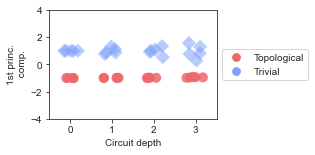

In [52]:
# Plot the 1D representation for different circuit depth
plt.figure(figsize=(3.0, 2.0))
df_toric = pd.DataFrame(data=data, columns = ['PC1', 'Depth', 'Phase'])
ax = sns.stripplot(x="Depth", y="PC1", hue='Phase', data=df_toric[df_toric["Phase"]=="Topological"], palette=['#ED686D'], orient="v",
                   edgecolor="black", marker="o", s=10, alpha=0.85, jitter=0.22)
ax = sns.stripplot(x="Depth", y="PC1", hue='Phase', data=df_toric[df_toric["Phase"]=="Trivial"], palette=['#80A3FA'], orient="v",
                   edgecolor="black", marker="D", s=10, alpha=0.55, jitter=0.22)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
ax.set_xlabel("Circuit depth")
ax.set_ylabel("1st princ.\n comp.")
ax.set_ylim(-4.0, 4.0);
